# CS 3540 Final Project Perchance...

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment, it should be under CS254/CS254-Assignments/netid-A1
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS254/CS254-FinalProj' # change this directory to yours
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['US_inflation_rates.csv', 'df_sex_unemployment_rates.csv', 'AudFinalProject.ipynb']


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# Load the datasets
sex_unemp = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'df_sex_unemployment_rates.csv'))
infl = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'US_inflation_rates.csv'))

# Convert date columns to datetime (important!)
sex_unemp['date'] = pd.to_datetime(sex_unemp['date'])
infl['date'] = pd.to_datetime(infl['date'])

# Merge on date
df = pd.merge(sex_unemp, infl, on="date", how="left")

# Rename inflation column
df = df.rename(columns={"value": "inflation"})

# Preview combined dataset
df.head()

,date,overall_rate,men_rate,women_rate,men_16_17_rate,women_16_17_rate,men_16_19_rate,women_16_19_rate,men_18_19_rate,women_18_19_rate,...,women_25_34_rate,men_25_54_rate,women_25_54_rate,men_35_44_rate,women_35_44_rate,men_45_54_rate,women_45_54_rate,men_55plus_rate,women_55plus_rate,inflation
0,1948-01-01,3.4,3.4,3.3,9.7,8.8,9.4,7.2,9.5,6.8,...,4.3,2.3,2.8,2.1,1.8,2.3,2.1,3.0,NaN,23.68
1,1948-02-01,3.8,3.6,4.5,13.0,13.2,10.8,8.9,9.2,6.8,...,5.1,2.6,3.7,2.5,2.6,2.6,3.3,2.9,NaN,23.67
2,1948-03-01,4.0,3.8,4.4,14.0,11.4,11.9,8.6,10.3,7.3,...,3.5,2.6,3.3,2.6,3.0,2.4,3.3,2.8,NaN,23.50
3,1948-04-01,3.9,3.8,4.3,11.6,10.6,9.8,9.2,8.6,8.6,...,3.8,2.8,3.5,2.7,3.5,2.5,3.1,2.9,NaN,23.82
4,1948-05-01,3.5,3.5,3.7,7.1,5.4,7.6,6.1,8.6,7.0,...,3.3,2.5,3.1,2.4,3.0,2.3,2.9,3.1,NaN,24.01


## Project description- Audrey
Recession Prediction Model via Classification

Predicting whether the U.S. is entering a recession using unemployment + inflation.

Methods:
- Logistic Regression
- Random Forest Classification
- Gradient Boosted Trees
- Train/test splits

In [7]:
#creating recession codes

recessions = [
    ("1948-11", "1949-10"),
    ("1953-07", "1954-05"),
    ("1957-08", "1958-04"),
    ("1960-04", "1961-02"),
    ("1969-12", "1970-11"),
    ("1973-11", "1975-03"),
    ("1980-01", "1980-07"),
    ("1981-07", "1982-11"),
    ("1990-07", "1991-03"),
    ("2001-03", "2001-11"),
    ("2007-12", "2009-06"),
    ("2020-02", "2020-04")
]

df["recession"] = 0
for start, end in recessions:
    mask = (df["date"] >= pd.to_datetime(start)) & (df["date"] <= pd.to_datetime(end))
    df.loc[mask, "recession"] = 1


In [8]:
#feature engineeering

data = df.sort_values("date").reset_index(drop=True)

lags = [1, 3, 6, 12]
for lag in lags:
    data[f"unemp_lag_{lag}"] = data["overall_rate"].shift(lag)
    data[f"infl_lag_{lag}"] = data["inflation"].shift(lag)

# Moving averages
data["unemp_ma_3"] = data["overall_rate"].rolling(3).mean()
data["unemp_ma_6"] = data["overall_rate"].rolling(6).mean()
data["infl_ma_3"]  = data["inflation"].rolling(3).mean()
data["infl_ma_6"]  = data["inflation"].rolling(6).mean()

# Month and Year (seasonality)
data["month"] = data["date"].dt.month
data["year"]  = data["date"].dt.year

# Drop early NA rows created by lags
data = data.dropna()


In [9]:
#feature selection from combined df

features = [
    "overall_rate", "inflation",
    "unemp_lag_1", "unemp_lag_3", "unemp_lag_6", "unemp_lag_12",
    "infl_lag_1", "infl_lag_3", "infl_lag_6", "infl_lag_12",
    "unemp_ma_3", "unemp_ma_6",
    "infl_ma_3", "infl_ma_6",
    "month"
]

X = data[features]
y = data["recession"].astype(int)


In [10]:
#train/test splits
cutoff = pd.to_datetime("2005-12-31")
train_mask = data["date"] <= cutoff
test_mask  = data["date"] > cutoff

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask], y[test_mask]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (144, 15)
Test size: (210, 15)


In [11]:
#modeling with random forest & gradient boosted trees
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=300, class_weight="balanced", random_state=42
    ),
    "Gradient Boosted Trees": GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, random_state=42
    )
}

results = {}

In [12]:
#fitting and evaluation
for name, model in models.items():

    print("\n====================================================")
    print(f"Training: {name}")
    print("====================================================")

    model.fit(X_train, y_train)

    # Probability scores
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # For models with decision_function only
        decision_scores = model.decision_function(X_test)
        y_proba = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())

    y_pred = model.predict(X_test)

    # Metrics
    auc = roc_auc_score(y_test, y_proba)
    avg_pr = average_precision_score(y_test, y_proba)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print(f"ROC AUC: {auc:.4f}")
    print(f"Avg Precision (PR-AUC): {avg_pr:.4f}")

    # Save results
    results[name] = (model, auc, avg_pr)


Training: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0     0.9872    0.4096    0.5789       188
           1     0.1591    0.9545    0.2727        22

    accuracy                         0.4667       210
   macro avg     0.5731    0.6821    0.4258       210
weighted avg     0.9004    0.4667    0.5469       210

Confusion Matrix:
[[ 77 111]
 [  1  21]]
ROC AUC: 0.6266
Avg Precision (PR-AUC): 0.1532

Training: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0     0.8930    0.8883    0.8907       188
           1     0.0870    0.0909    0.0889        22

    accuracy                         0.8048       210
   macro avg     0.4900    0.4896    0.4898       210
weighted avg     0.8086    0.8048    0.8067       210

Confusion Matrix:
[[167  21]
 [ 20   2]]
ROC AUC: 0.4136
Avg Precision (PR-AUC): 0.1379

Training: Gradient Boosted Trees

Classification Report:
        

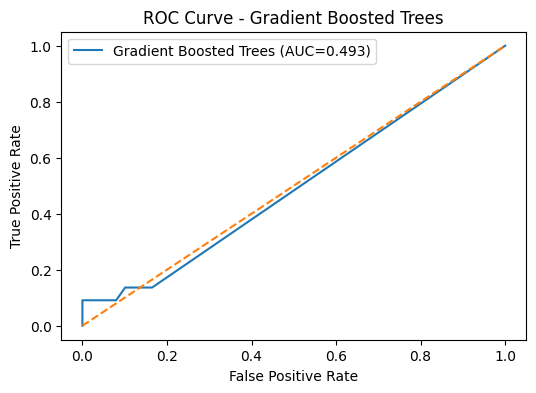

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.title(f"ROC Curve - {name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

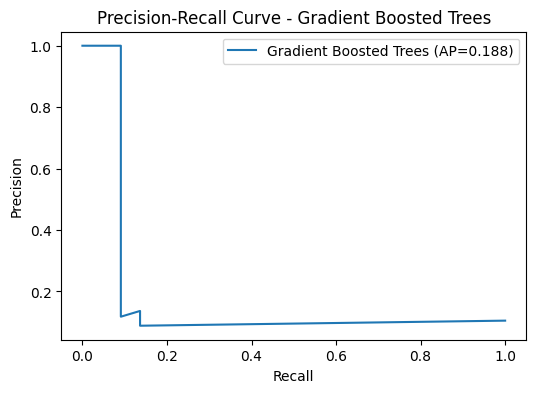

In [14]:
# PRECISION-RECALL CURVE
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"{name} (AP={avg_pr:.3f})")
plt.title(f"Precision-Recall Curve - {name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [15]:
#which model to use?
print("\n==================== MODEL SUMMARY ====================")
for name, (model, auc, pr) in results.items():
    print(f"{name}:  ROC AUC={auc:.3f},  PR-AUC={pr:.3f}")



==================== MODEL SUMMARY ====================
Logistic Regression:  ROC AUC=0.627,  PR-AUC=0.153
Random Forest:  ROC AUC=0.414,  PR-AUC=0.138
Gradient Boosted Trees:  ROC AUC=0.493,  PR-AUC=0.188


##Building a Neural Network



Training: Neural Network (MLP)

Classification Report:
              precision    recall  f1-score   support

           0     0.8952    1.0000    0.9447       188
           1     0.0000    0.0000    0.0000        22

    accuracy                         0.8952       210
   macro avg     0.4476    0.5000    0.4724       210
weighted avg     0.8015    0.8952    0.8458       210

Confusion Matrix:
[[188   0]
 [ 22   0]]
ROC AUC: 0.7669
Avg Precision (PR-AUC): 0.2314


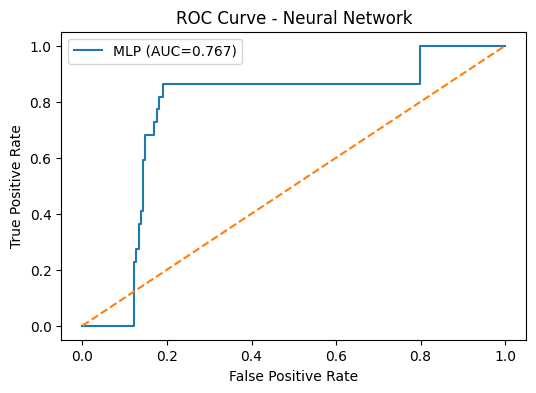

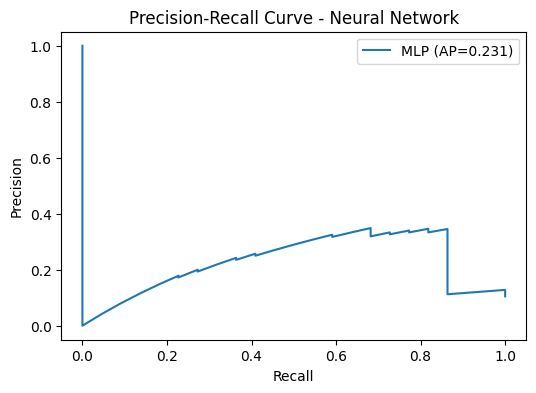

In [17]:
from sklearn.neural_network import MLPClassifier

# ---------------------------
#  NEURAL NETWORK CLASSIFIER
# ---------------------------

print("\n====================================================")
print("Training: Neural Network (MLP)")
print("====================================================")

# MLP settings – you may tune these later
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),   # 2-layer NN: 64 → 32 neurons
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=2000,
    random_state=42
)

# Fit model
mlp.fit(X_train, y_train)

# Get probability scores
y_proba = mlp.predict_proba(X_test)[:, 1]
y_pred  = mlp.predict(X_test)

# Evaluation metrics
auc = roc_auc_score(y_test, y_proba)
avg_pr = average_precision_score(y_test, y_proba)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"ROC AUC: {auc:.4f}")
print(f"Avg Precision (PR-AUC): {avg_pr:.4f}")

# Save into results dict to compare later
results["Neural Network"] = (mlp, auc, avg_pr)


# ---------------------------
#  ROC CURVE PLOT
# ---------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"MLP (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve - Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ---------------------------
#  PRECISION-RECALL CURVE
# ---------------------------
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"MLP (AP={avg_pr:.3f})")
plt.title("Precision-Recall Curve - Neural Network")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


##Deeper neural network

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,377 (52.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.3416 - loss: 0.9426 - val_accuracy: 1.0000 - val_loss: 0.6284
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4545 - loss: 0.8061 - val_accuracy: 1.0000 - val_loss: 0.6279
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5198 - loss: 0.7992 - val_accuracy: 1.0000 - val_loss: 0.6327
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5115 - loss: 0.7676 - val_accuracy: 0.8621 - val_loss: 0.6373
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5090 - loss: 0.7393 - val_accuracy: 0.6552 - val_loss: 0.6442
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5883 - loss: 0.6485 - val_accuracy: 0.6207 - val_loss: 0.6474
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5525 - loss: 0.6480 - val_accuracy: 0.6552 - val_loss: 0.6469
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6821 - loss: 0.6021 - val_accuracy: 0.6552 - val_lo

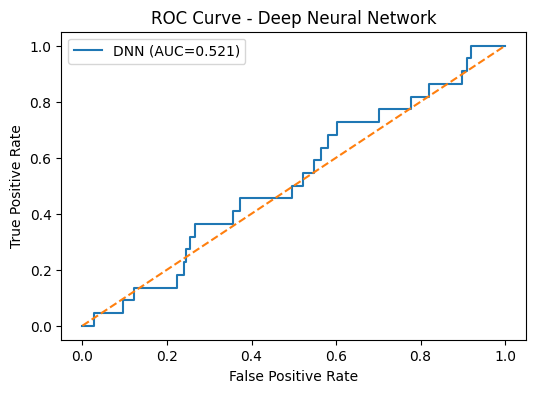

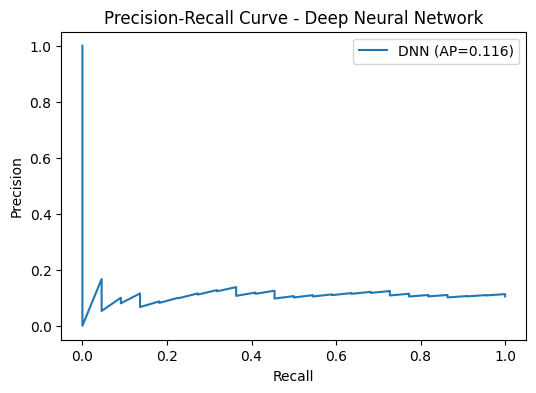

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# -----------------------------------
#  SCALE INPUTS (important for NN!)
# -----------------------------------
scaler_nn = StandardScaler()
X_train_scaled = scaler_nn.fit_transform(X_train)
X_test_scaled = scaler_nn.transform(X_test)

# -----------------------------------
#  BUILD DEEP NEURAL NETWORK
# -----------------------------------
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Output: recession probability
])

model_nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_nn.summary()

# -----------------------------------
#  TRAIN MODEL WITH EARLY STOPPING
# -----------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model_nn.fit(
    X_train_scaled, y_train,
    validation_split=0.20,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# -----------------------------------
#  PREDICTIONS
# -----------------------------------
y_proba = model_nn.predict(X_test_scaled).flatten()
y_pred = (y_proba >= 0.5).astype(int)

# -----------------------------------
#  EVALUATION
# -----------------------------------
auc = roc_auc_score(y_test, y_proba)
avg_pr = average_precision_score(y_test, y_proba)

print("\n====================================================")
print("Deep Neural Network Performance")
print("====================================================")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"ROC AUC: {auc:.4f}")
print(f"Avg Precision (PR-AUC): {avg_pr:.4f}")

# Save results
results["Deep Neural Network"] = (model_nn, auc, avg_pr)

# -----------------------------------
#  ROC CURVE
# -----------------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"DNN (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve - Deep Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# -----------------------------------
#  PRECISION–RECALL CURVE
# -----------------------------------
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"DNN (AP={avg_pr:.3f})")
plt.title("Precision-Recall Curve - Deep Neural Network")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()



##Attempt 2

Epoch 1/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.4817 - loss: 0.8929 - val_accuracy: 0.8966 - val_loss: 0.7044
Epoch 2/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5453 - loss: 0.8782 - val_accuracy: 0.9310 - val_loss: 0.6896
Epoch 3/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5872 - loss: 0.8198 - val_accuracy: 0.9310 - val_loss: 0.6753
Epoch 4/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4815 - loss: 0.8337 - val_accuracy: 0.9310 - val_loss: 0.6641
Epoch 5/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6261 - loss: 0.7677 - val_accuracy: 0.9310 - val_loss: 0.6495
Epoch 6/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5828 - loss: 0.7309 - val_accuracy: 0.9655 - val_loss: 0.6230
Epoch 7/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6099 - loss: 0.7548 - val_accuracy: 0.9655 - val_loss: 0.6087
Epoch 8/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6106 - loss: 0.7519 - val_accuracy: 1.0000 - val_loss: 0.585

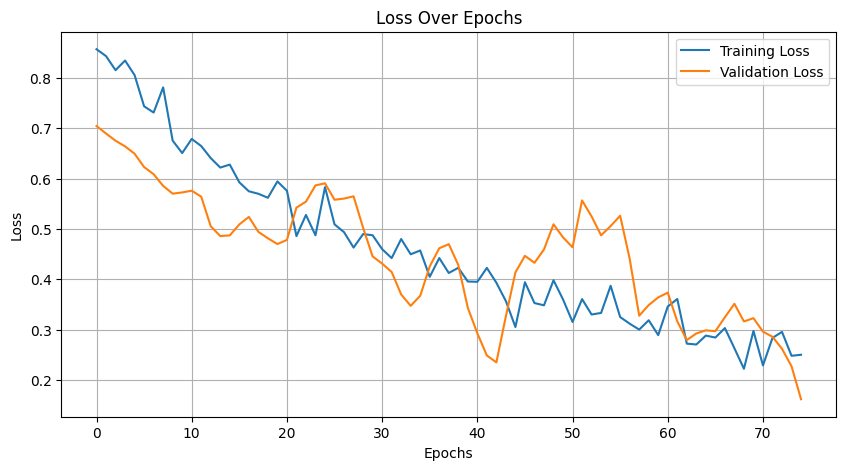

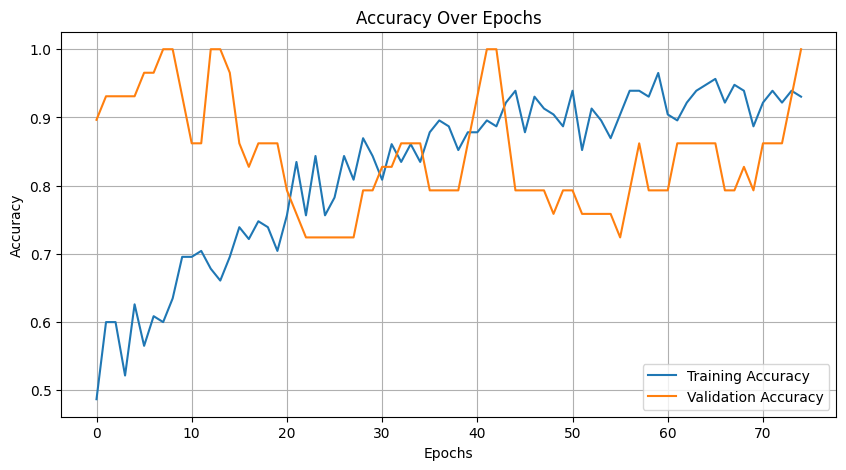

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ------------------------------------
# Train/Validation Split
# ------------------------------------
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

# Scale features
scaler_nn = StandardScaler()
X_train_final_scaled = scaler_nn.fit_transform(X_train_final)
X_val_scaled = scaler_nn.transform(X_val)
X_test_scaled = scaler_nn.transform(X_test)

# ------------------------------------
# Deep NN Model
# ------------------------------------
deep_model = Sequential([
    Dense(256, activation='gelu', kernel_regularizer=l2(1e-4), input_shape=(X_train_final_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='gelu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='gelu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.25),

    Dense(32, activation='gelu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='gelu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

deep_model.compile(
    optimizer=Adam(learning_rate=0.0007),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# ------------------------------------
# Train Model
# ------------------------------------
history = deep_model.fit(
    X_train_final_scaled, y_train_final,
    validation_data=(X_val_scaled, y_val),
    epochs=75,
    batch_size=16,
    verbose=1
)

# ----------------------------------------------------
# Plot Loss
# ----------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------
# Plot Accuracy
# ----------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

